Here I will try and prove that my model isn't working. First, I will run my optimizer 3 times to see if I get different results.

Now I will compare how the mode matching compares to actually tracing the particle. I will also inspect these swarms to see that they make sense.




In [1]:
from latticeKnobOptimizer import LatticeOptimizer
import dill
import matplotlib.pyplot as plt
from ParticleClass import Swarm,Particle
from ParticleTracerLatticeClass import ParticleTracerLattice
import numpy as np
import time
from SwarmTracerClass import SwarmTracer
from optimizerHelperFunctions import generate_Ring_Lattice,generate_Injector_Lattice
parallel=False
# ----------Solution-----------
# injector element spacing optimum configuration: [0.10970817 0.13830605]
# storage ring tuned params 1 optimum configuration: [0.02000886 0.03119919 0.01324413 0.36503544 1.15110092 1.00777664
#                                                     0.12208005 0.03236198]
# storage ring tuned params 2 optimum configuration: [0.66706644 0.78041371]
# cost: 0.5396119504745164
# survival: 46.03880495254836
# scipy message: Optimization terminated successfully.
# ----------------------------

XRing=[0.02000886, 0.03119919, 0.01324413, 0.36503544 ,1.15110092, 1.00777664 ,0.12208005 ,0.03236198]
rpLens,rpLensFirst,rpLensLast,LLens,injectorFactor, rpInjectorFactor, LmCombiner, rpCombiner=XRing

PTL_Ring=generate_Ring_Lattice(rpLens,rpLensFirst,rpLensLast,LLens,injectorFactor, rpInjectorFactor,
                               LmCombiner, rpCombiner,parallel=parallel)
PTL_Injector=generate_Injector_Lattice(injectorFactor, rpInjectorFactor, LmCombiner, rpCombiner,parallel=parallel)
XSpacing=[0.66706644 ,0.78041371,0.10970817 ,0.13830605]
XLatticeSpace= XSpacing[:2]
XInjectorSpace= XSpacing[2:]





# file=open('ringFile','wb')
# dill.dump(PTL_Ring,file)
# file=open('ringFile','rb')
# PTL_Ring=dill.load(file)



optimizer=LatticeOptimizer(PTL_Ring,PTL_Injector)
# optimizer.numParticlesRing=50000
# optimizer.numParticlesInjector=1000
elementIndices=(1,8)
ringTuningBounds = [(.2, .8), (.2, .8)]
injectorTuningBounds = [(.05, .4), (.05, .4)]
optimizer.catch_Optimizer_Errors(ringTuningBounds, elementIndices, 'spacing')
optimizer.initialize_Optimizer(elementIndices,'spacing',ringTuningBounds,injectorTuningBounds)
optimizer.update_Ring_Lattice(XLatticeSpace)
optimizer.update_Injector_Lattice(XInjectorSpace)

# file=open('ringFile','wb')
# dill.dump(PTL_Ring,file)



In [7]:
#trace through injector
fastMode=True
h=5e-6
optimizer.spotCaptureDiam=.01
optimizer.gamma_Space=4.5e-3
optimizer.generate_Swarms()
swarm=optimizer.swarmInjectorInitial
# swarm=Swarm()
# swarm.add_Particle()
swarmInjectorTraced = optimizer.swarmTracerInjector.trace_Swarm_Through_Lattice(
    swarm
    , h, 1.0, parallel=False,
    fastMode=fastMode, copySwarm=True,
    accelerated=True,energyCorrection=False,stepsBetweenLogging=4)
swarmEnd = optimizer.move_Survived_Particles_In_Injector_Swarm_To_Origin(swarmInjectorTraced, copyParticles=True)
# print(swarmEnd.num_Particles())
swarmRingInitial = optimizer.swarmTracerRing.move_Swarm_To_Combiner_Output(swarmEnd, copySwarm=False,scoot=True)
# optimizer.latticeInjector.show_Lattice(swarm=swarmInjectorTraced,trueAspectRatio=False,showTraceLines=True,traceLineAlpha=.25,showMarkers=True,finalCoords=False,showRelativeSurvival=False) #careful about which swarm
swarmRingInitial.num_Particles(),optimizer.swarmInjectorInitial.num_Particles()

(198, 267)

In [9]:
#trace through lattice
import multiprocess as mp
def params(T,energyCons=True):
    fastMode=True
    optimizer.T=T
    swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, optimizer.T, parallel=False,
                                                            fastMode=fastMode, accelerated=True, copySwarm=True,energyCorrection=energyCons)
    # PTL_Ring.show_Lattice(swarm=swarmTraced,showMarkers=False,showTraceLines=True,traceLineAlpha=.5)
    # print(swarmTraced.lattice_Flux())
    # print(sum([p.probability*p.revolutions for p in swarmTraced]))
    survivalFrac=swarmTraced.num_Particles(weighted=True)/optimizer.swarmInjectorInitial.num_Particles(weighted=True)
    maxFluxMult=T*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
    swarmFluxMult=swarmTraced.weighted_Flux_Multiplication()
    return survivalFrac*swarmFluxMult/maxFluxMult

TArr=np.logspace(np.log10(10.0/200.0),np.log10(30),10)
with mp.Pool(10) as pool:
    results=1e2*np.asarray(pool.map(params,TArr,chunksize=1))

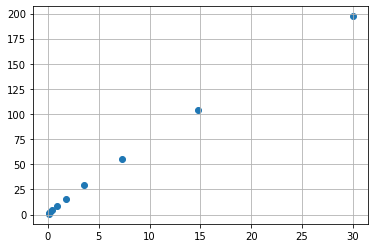

In [12]:
resultsFluxMult=1e-2*results*TArr*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
plt.scatter(TArr,resultsFluxMult)
plt.grid()
plt.show()

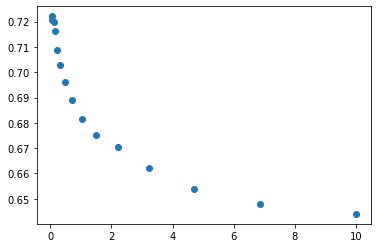

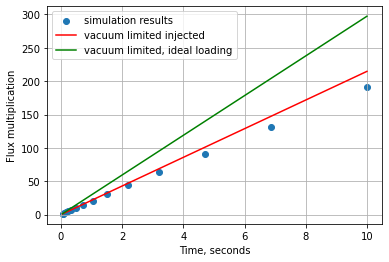

(191.41160528008507, 1.4860377042075357)

In [23]:
flux=results[:,0]
fluxMax=results[:,1]
vacuumLine=(TArr*flux[0]/TArr[0])
maxLIne=(TArr*fluxMax[0]/TArr[0])
plt.scatter(TArr,flux/fluxMax)
plt.show()
plt.scatter(TArr,flux,label='simulation results')
plt.plot(TArr,vacuumLine,label='vacuum limited injected',c='r')
plt.plot(TArr,maxLIne,label='vacuum limited, ideal loading',c='g')
plt.ylabel('Flux multiplication')
plt.xlabel('Time, seconds')
plt.grid()
plt.legend()
plt.show()
flux[-1],fluxMax[0]

# look at energy conservation

In [41]:
swarmETest=Swarm()
swarmETest.particles=swarmRingInitial.particles[:11]
swarmETest.particles=[swarmRingInitial.particles[5]]
def trace_ETest_Swarm(T):
    optimizer.T=T
    swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmETest, optimizer.h, optimizer.T, parallel=False,
                                                                    fastMode=False, accelerated=True, copySwarm=True,energyCorrection=True)
    return swarmTraced
t=time.time()
swarmTraced=trace_ETest_Swarm(10.0)
print(time.time()-t)

114.5606300830841


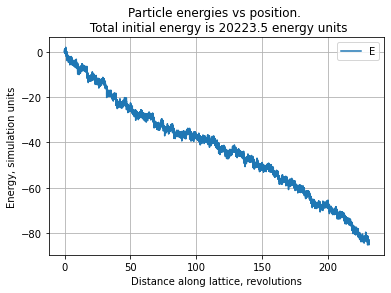

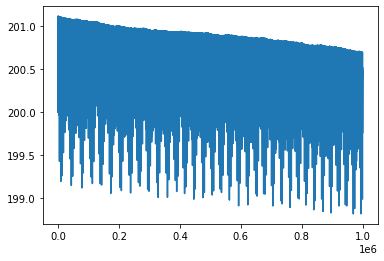

In [40]:
%matplotlib inline
# for particle in swarmTraced:
#     particle.plot_Energies()
swarmTraced.particles[0].plot_Energies(showOnlyTotalEnergy=True)
swarmTraced.particles[0].revolutions
p0Arr=swarmTraced.particles[0].p0Arr
plt.plot(p0Arr)
plt.show()

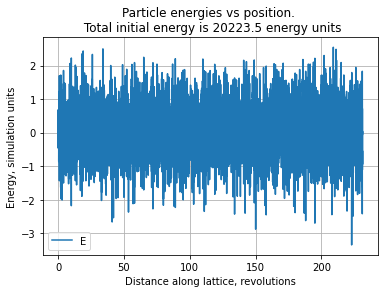

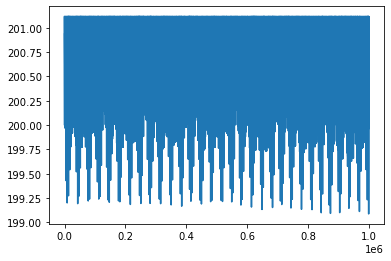

In [42]:
%matplotlib inline
# for particle in swarmTraced:
#     particle.plot_Energies()
swarmTraced.particles[0].plot_Energies(showOnlyTotalEnergy=True)
swarmTraced.particles[0].revolutions
p0Arr=swarmTraced.particles[0].p0Arr
plt.plot(p0Arr)
plt.show()